In [1]:
import intake
import pandas as pd
import pprint
import fsspec

import numpy as np
import xarray as xr
import xgcm
import xesmf as xe
import s3fs

import matplotlib.pyplot as plt
%matplotlib inline

from fastjmd95 import jmd95numba

In [2]:
ht_42 = xr.open_dataset('/home/jovyan/amoc_heat_transport/ht_42.nc').ht_42
ht_34 = xr.open_dataset('/home/jovyan/amoc_heat_transport/ht_34.nc').ht_34
ht_26 = xr.open_dataset('/home/jovyan/amoc_heat_transport/ht_26.nc').ht_26
ht_5S = xr.open_dataset('/home/jovyan/amoc_heat_transport/ht_5S.nc').ht_5S

MOC_42 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_42.nc').MOC_42.sel(member_id=slice(1,36))
MOC_34 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_34.nc').MOC_34.sel(member_id=slice(1,36))
MOC_26 = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_26.nc').MOC_26.sel(member_id=slice(1,36))
MOC_5S = xr.open_dataset('/home/jovyan/amoc_heat_transport/MOC_5S.nc').MOC_5S.sel(member_id=slice(1,36))

In [3]:
MOC_42_smoothed = MOC_42.rolling(time=24).mean().dropna("time",how='all')
MOC_34_smoothed = MOC_34.rolling(time=24).mean().dropna("time",how='all')
MOC_26_smoothed = MOC_26.rolling(time=24).mean().dropna("time",how='all')
MOC_5S_smoothed = MOC_5S.rolling(time=24).mean().dropna("time",how='all')

MOC_42_smoothed10 = MOC_42_smoothed.rolling(time=12*10).mean().dropna("time",how='all')
MOC_34_smoothed10 = MOC_34_smoothed.rolling(time=12*10).mean().dropna("time",how='all')
MOC_26_smoothed10 = MOC_26_smoothed.rolling(time=12*10).mean().dropna("time",how='all')
MOC_5S_smoothed10 = MOC_5S_smoothed.rolling(time=12*10).mean().dropna("time",how='all')

ht_42_10 = ht_42.rolling(time=12*10).mean().dropna("time",how='all')
ht_34_10 = ht_34.rolling(time=12*10).mean().dropna("time",how='all')
ht_26_10 = ht_26.rolling(time=12*10).mean().dropna("time",how='all')
ht_5S_10 = ht_5S.rolling(time=12*10).mean().dropna("time",how='all')

In [4]:
MOC_42_smoothed2 = MOC_42_smoothed-MOC_42_smoothed10
MOC_34_smoothed2 = MOC_34_smoothed-MOC_34_smoothed10
MOC_26_smoothed2 = MOC_26_smoothed-MOC_26_smoothed10
MOC_5S_smoothed2 = MOC_5S_smoothed-MOC_5S_smoothed10

ht_42_2 = ht_42-ht_42_10
ht_34_2 = ht_34-ht_34_10
ht_26_2 = ht_26-ht_26_10
ht_5S_2 = ht_5S-ht_5S_10

rho0=1029 
cp=3994
factor = rho0*cp/10**12

In [6]:
cov_34 = xr.cov(ht_34_2,MOC_34_smoothed2,'time')/MOC_34_smoothed2.std('time')/ht_34_2.std('time')
cov_26 = xr.cov(ht_26_2,MOC_26_smoothed2,'time')/MOC_26_smoothed2.std('time')/ht_26_2.std('time')
cov_5S = xr.cov(ht_5S_2,MOC_5S_smoothed2,'time')/MOC_5S_smoothed2.std('time')/ht_5S_2.std('time')

cov_34_10 = xr.cov(ht_34_10,MOC_34_smoothed10,'time')/MOC_34_smoothed10.std('time')/ht_34_10.std('time')
cov_26_10 = xr.cov(ht_26_10,MOC_26_smoothed10,'time')/MOC_26_smoothed10.std('time')/ht_26_10.std('time')
cov_5S_10 = xr.cov(ht_5S_10,MOC_5S_smoothed10,'time')/MOC_5S_smoothed10.std('time')/ht_5S_10.std('time')

In [7]:
df1 = pd.DataFrame({'cov_34':cov_34.values,'cov_26':cov_26.values,'cov_5S':cov_5S.values},index =np.arange(1,36))

df2 = pd.DataFrame({'cov_34':cov_34_10.values,'cov_26':cov_26_10.values,'cov_5S':cov_5S_10.values},index =np.arange(1,36))

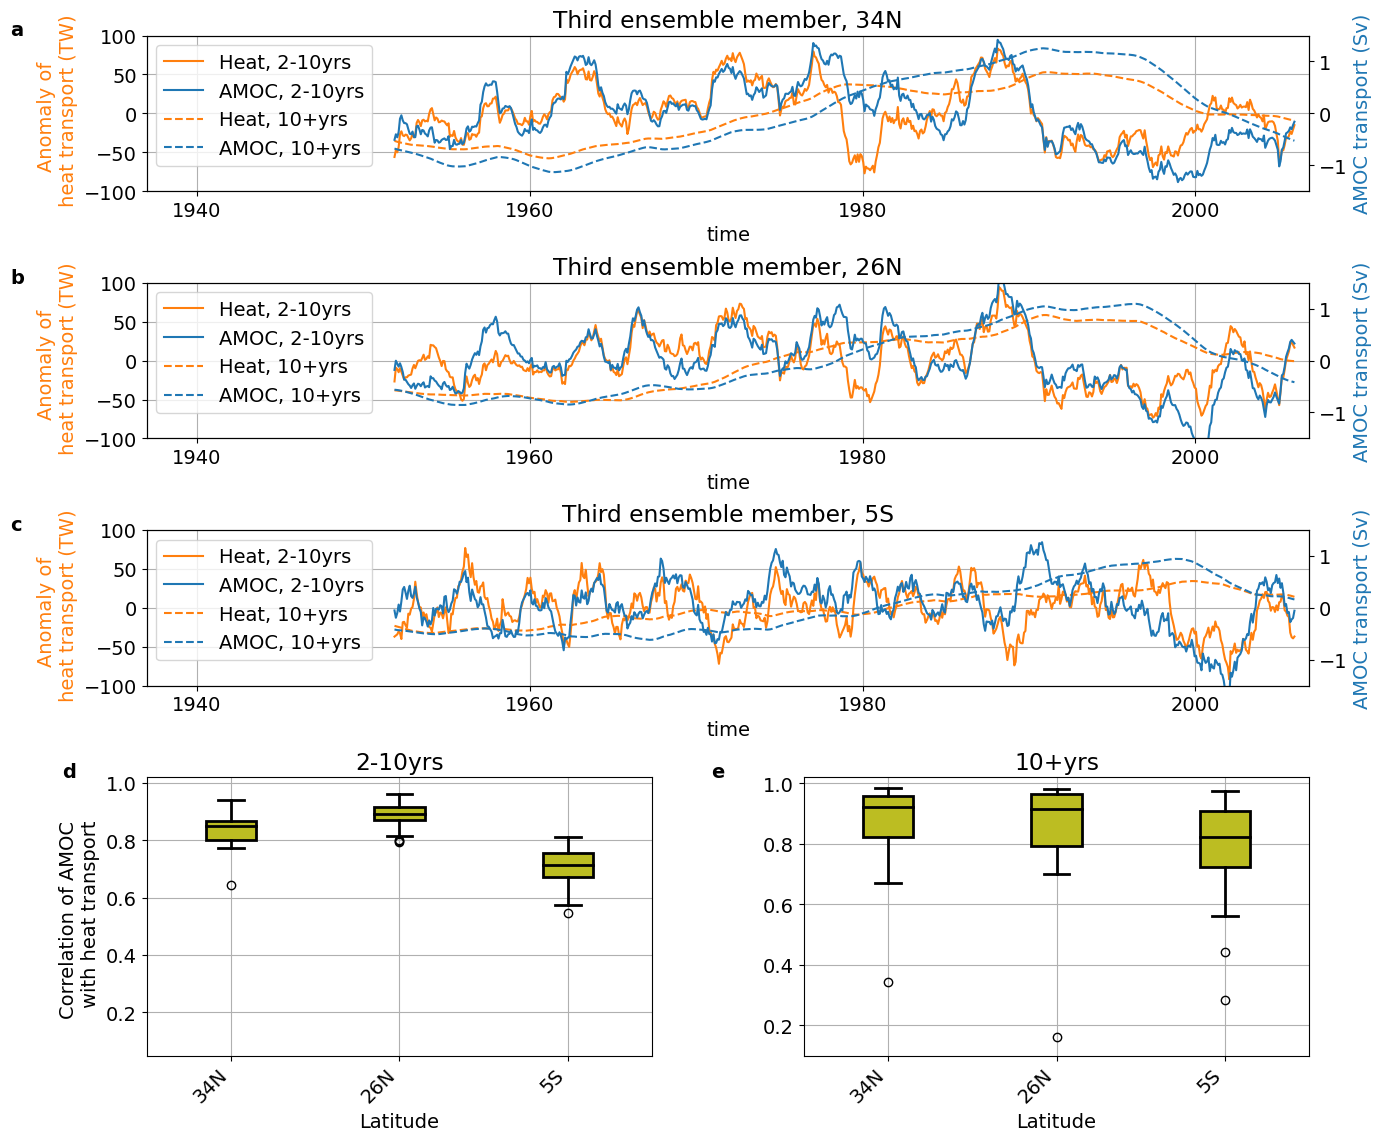

In [8]:
import matplotlib.gridspec as gridspec

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(15,12))


timeslice = slice('1940-01-01','2016-02-01')

fig = plt.gcf()
gs = gridspec.GridSpec(5, 2,hspace=0.7,wspace=0.3,height_ratios=[1,1,1,0.6,0.6])

ax1 = fig.add_subplot(gs[0,0:2])
lns1 = ((ht_34_2-ht_34_2.mean('time'))*factor).sel(member_id=3).plot(ax=ax1,label='Heat, 2-10yrs',color='tab:orange')
ax1a = ax1.twinx()
lns2 = (MOC_34_smoothed2.sel(member_id=3)/10**6).plot(ax=ax1a,label='AMOC, 2-10yrs',color='tab:blue')
lns3 = ((ht_34_10-ht_34_10.mean('time'))*factor).sel(member_id=3).plot(ax=ax1,label='Heat, 10+yrs',color='tab:orange',linestyle='--')
lns4 = ((MOC_34_smoothed10-MOC_34_smoothed10.mean('time')).sel(member_id=3)/10**6).plot(ax=ax1a,label='AMOC, 10+yrs',color='tab:blue',linestyle='--')

ax1.set_ylabel('Anomaly of \n heat transport (TW)',color='tab:orange')
ax1a.set_ylabel('AMOC transport (Sv)',color='tab:blue')
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.grid()
plt.xlim(-23000,2500)
ax1.set_ylim(-100,100)
ax1a.set_ylim(-1.5,1.5)
ax1.set_title('Third ensemble member, 34N')
ax1a.set_title('')
plt.xlabel('')

plt.text(-26000, 1.5, 'a',fontsize=14, weight='bold')

ax2 = fig.add_subplot(gs[1,0:2])
lns1 = ((ht_26_2-ht_26_2.mean('time'))*factor).sel(member_id=3).plot(ax=ax2,label='Heat, 2-10yrs',color='tab:orange')
ax2a = ax2.twinx()
lns2 = (MOC_26_smoothed2.sel(member_id=3)/10**6).plot(ax=ax2a,label='AMOC, 2-10yrs',color='tab:blue')
lns3 = ((ht_26_10-ht_26_10.mean('time'))*factor).sel(member_id=3).plot(ax=ax2,label='Heat, 10+yrs',color='tab:orange',linestyle='--')
lns4 = ((MOC_26_smoothed10-MOC_26_smoothed10.mean('time')).sel(member_id=3)/10**6).plot(ax=ax2a,label='AMOC, 10+yrs',color='tab:blue',linestyle='--')

ax2.set_ylabel('Anomaly of \n heat transport (TW)',color='tab:orange')
ax2a.set_ylabel('AMOC transport (Sv)',color='tab:blue')
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)
ax2.grid()
plt.xlim(-23000,2500)
ax2.set_ylim(-100,100)
ax2a.set_ylim(-1.5,1.5)
ax2.set_title('Third ensemble member, 26N')
ax2a.set_title('')
plt.xlabel('')

plt.text(-26000, 1.5, 'b',fontsize=14, weight='bold')

ax3 = fig.add_subplot(gs[2,0:2])
lns1 = ((ht_5S_2-ht_5S_2.mean('time'))*factor).sel(member_id=3).plot(ax=ax3,label='Heat, 2-10yrs',color='tab:orange')
ax3a = ax3.twinx()
lns2 = (MOC_5S_smoothed2.sel(member_id=3)/10**6).plot(ax=ax3a,label='AMOC, 2-10yrs',color='tab:blue')
lns3 = ((ht_5S_10-ht_5S_10.mean('time'))*factor).sel(member_id=3).plot(ax=ax3,label='Heat, 10+yrs',color='tab:orange',linestyle='--')
lns4 = ((MOC_5S_smoothed10-MOC_5S_smoothed10.mean('time')).sel(member_id=3)/10**6).plot(ax=ax3a,label='AMOC, 10+yrs',color='tab:blue',linestyle='--')

ax3.set_ylabel('Anomaly of \n heat transport (TW)',color='tab:orange')
ax3a.set_ylabel('AMOC transport (Sv)',color='tab:blue')
lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax3.legend(lns, labs, loc=0)
ax3.grid()
plt.xlim(-23000,2500)
ax3.set_ylim(-100,100)
ax3a.set_ylim(-1.5,1.5)
ax3.set_title('Third ensemble member, 5S')
ax3a.set_title('')
plt.xlabel('')

plt.text(-26000, 1.5, 'c',fontsize=14, weight='bold')


ax3 = fig.add_subplot(gs[3:7, 0])
boxprops = dict(linewidth=2.0, color='black')
whiskerprops = dict(linestyle='-',linewidth=2.0, color='black')
medianprops = dict(linestyle='-',linewidth=2.0, color='black')
capprops = dict(linestyle='-',linewidth=2.0, color='black')
ax1,row = df1.boxplot(patch_artist=True,rot=45,figsize=(6, 8),return_type='both',
                     boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops)
for i,box in enumerate(row['boxes']):
    box.set_facecolor("tab:olive")
plt.xlabel('Latitude')
plt.ylabel('Correlation of AMOC \n with heat transport')
plt.xticks([1, 2, 3], ['34N', '26N','5S'],ha='right')

plt.ylim(0.05,1.02)
plt.title('2-10yrs')

plt.text(0, 1.02, 'd',fontsize=14, weight='bold')

ax4 = fig.add_subplot(gs[3:7, 1])

boxprops = dict(linewidth=2.0, color='black')
whiskerprops = dict(linestyle='-',linewidth=2.0, color='black')
medianprops = dict(linestyle='-',linewidth=2.0, color='black')
capprops = dict(linestyle='-',linewidth=2.0, color='black')
ax1,row = df2.boxplot(patch_artist=True,rot=45,figsize=(6, 8),return_type='both',
                     boxprops=boxprops, whiskerprops=whiskerprops, medianprops=medianprops, capprops=capprops)

for i,box in enumerate(row['boxes']):
    box.set_facecolor("tab:olive")
plt.xticks([1, 2, 3], ['34N', '26N','5S'],ha='right')

plt.ylim(0.1,1.02)
plt.title('10+yrs')
plt.xlabel('Latitude')
#plt.text(-40, 1.1, 'c',fontsize=14)

plt.text(-0.05, 1.02, 'e',fontsize=14, weight='bold')

plt.subplots_adjust(bottom=0.1,top=0.95)

fig = plt.gcf()
fig.savefig('variance_explained_lat.png')